<h1 align="center"> Fall 2022 Data Science Intern Challenge </h1>

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

- Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
- What metric would you report for this dataset?
- What is its value?

**Summary of Answers** 

1. Median, $284, should be used as it is less affected by outliers. And outliers causes the calculated AOV to be skewed

2. The 3 different techniques to calculate the true AOV value are:
    - Log Transformation
    - Removing Outliers
    - Random Sampling
    
3. All 3 approaches yielded similar results
    - Log Transformation: \$285.02
    - Removing Outliers: \$293.72
    - Random Sampling: \$293.74
    
    Taking the median of 284 into account, we can deduce that the true AOV must be in the range 282 to 294.
    
From the question description, we can deduce that there seems to be an error that takes the average order value (AOV) very high. Perhaps there exists outliers that are doing this. Keeping this in mind - we will first explore our dataset to get a better understanding of the values we are working with.

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [3]:
df = pd.read_csv("ShopifyData.csv")

In [4]:
df['order_amount'].describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

From the metrics above we notice a few things. The AOV calculated is simply the mean of the order_amount column. Furthermore, the range (max-min) and standard deviation (std) of the data are very large relative to the median (50%). This suggests that the data is skewed and there exists outliers. The reason the calculated AOV is rather large is because it is simply the mean of the data. Mean is a metric that can be disturbed by outliers.

To confirm, and have a visual example we will take a look at the box plot diagram for the data.

Text(0.5, 1.0, '(Logged) Order Amount Box Plot')

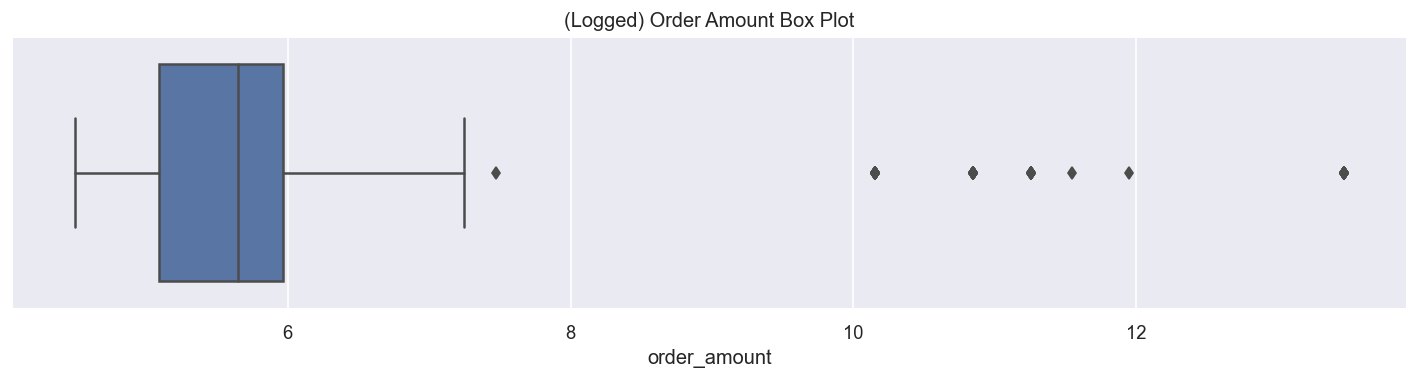

In [8]:
figure(figsize=(15, 3), dpi=120)
sns.set_theme()
compressed_order_amount = np.log(df['order_amount'])
sns.boxplot(x=compressed_order_amount).set_title('(Logged) Order Amount Box Plot')

## What could be wrong with the calculation?

In the calculation that was done, the AOV was simply the mean of the `order_amount` column. Outliers were not taken into account. The reason this does not work is because outliers affect the mean. To calculate the mean, we use the following formula:

$$ {\displaystyle {\bar{x}}={\frac {\sum _{i=1}^{n}{x_{i}}}{n}}} $$

Each value (outlier or not) is added into the summation in the numerator. Meaning every value has a direct impact on the mean. This is why mean is a metric that is sensitive to outliers.

A simple solution that is a better metric for this purpose is to use any that is not affected by outliers as much. For example - median. (More methods are discussed below)

In [6]:
df.order_amount.median()

284.0

## Attempting to calculate a better AOV

In the following section we will discuss 3 different approaches to calculate a more accurate and reliable AOV. At present the best estimate we have is the median `(284.0)`. The 3 techniques that will be discussed are:
<ul>
    <li>Log transformation</li>
    <li>Removing Outliers</li>
    <li>Random sampling</li>
    
</ul>

### Log Transformation

Log transformation is a technique that can be used in an attempt to transform skewed data to data that resembles a normal distribution bell curve. However, there is one caveat. For the best results from a log transformation the original data must follow or resemble a log-normal distribution curve.

First lets take a look at what the data looks like before any transformation is applied.

Note: After sorting in ascending order the last 70 `order_amount` values have been ignored in the diagram - this is so that the graph shape is clearly visable

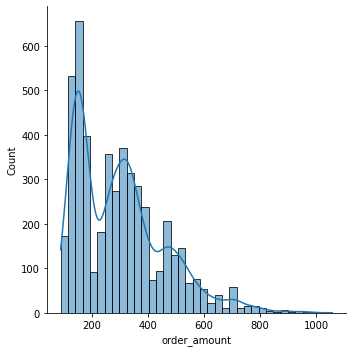

In [7]:
sorted_order_amount = df['order_amount'].sort_values()
sns.displot(sorted_order_amount.head(4930), kde='True')

As we can see from the graph above the data doesn't follow the best log-normal distribution. Despite this we will move forward to see what results we get from this approach.

Now lets take a look at what the distribution looks like after the log transformation has been applied

Note: `commpressed_order_amount` was created earlier in the box plot diagram so that the x-axis scale was visible

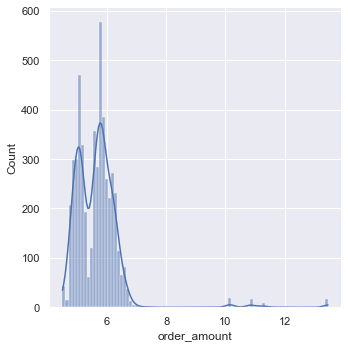

In [9]:
sns.displot(compressed_order_amount, kde='True')

Although the diagram above is not a perfect normal distribution curve, it is more "normal" than our original data. Despite there still being a right skew the standard deviation of the values has decreased. To get the "true" mean using this method we must "un-log" (exp) the logged mean

In [10]:
compressed_order_amount.describe()

count    5000.000000
mean        5.652561
std         0.844728
min         4.499810
25%         5.093750
50%         5.648974
75%         5.966147
max        13.464534
Name: order_amount, dtype: float64

In [11]:
np.exp(np.mean(compressed_order_amount))

285.0204747254945

### Removing Outliers

The most obvious approach would be to remove the outliers entirely and calculate the new mean from there. However doing this is not always feasible. For larger datasets this can lead to heavier computations. Where as for smaller datasets removing outliers could create a bias in the dataset. If any of the outliers are legitimate then we would simply be removing data that may have been informative. 

Nevertheless, we will explore this approach as well to see what result it gives us.

The method used for this approach is the interquartile range method. Wherein we find an upper and lower bound - and if a particular value does not fit within this range it is marked as an outlier.

In [12]:
Q1 = df['order_amount'].quantile(0.25) # Lower Quartile
Q3 = df['order_amount'].quantile(0.75) # Upper Quartile
IQR = Q3 - Q1                          # Inter Quartile Range
LB = Q1 - 1.5 * IQR                    # Lower Bound
UB = Q3 + 1.5 * IQR                    # Upper Bound
LB, UB

(-177.5, 730.5)

Any `order_amount` values that are not between `-177.5` and `730.5` will be considered as outliers 

In [13]:
order_amount_voidOutliers = df['order_amount'][df['order_amount'].between(LB,UB)]

Text(0.5, 1.0, '(Logged) Order Amount Box Plot (Outliers Removed)')

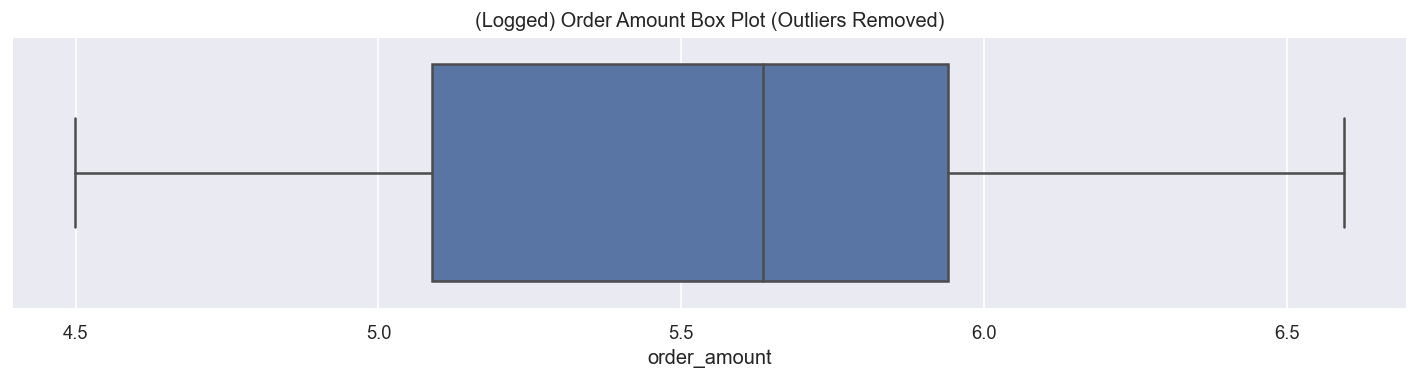

In [14]:
figure(figsize=(15, 3), dpi=120)
sns.set_theme()
compressed_order_amount = np.log(order_amount_voidOutliers)
sns.boxplot(x=compressed_order_amount).set_title('(Logged) Order Amount Box Plot (Outliers Removed)')

As we can see from the box plot above - there are no longer any outliers left in our data. From here we can see how many outliers there were and then simply calculate the mean and standard deviation of the `order_amount_voidOutliers` column.

In [15]:
len(df['order_amount'])-len(order_amount_voidOutliers)

141

In [16]:
np.mean(order_amount_voidOutliers), np.std(order_amount_voidOutliers)

(293.7153735336489, 144.43852968691695)

### Random Sampling

Random sampling is a method based off of the central limit theorem. The central limit theorem states that if you have a population with mean `μ` and standard deviation `σ` and take sufficiently large random samples from the population with replacement , then the distribution of the sample means will be approximately normally distributed.

In simpler words, if we take large samples of our population - then the mean of all the samples will be approximately equal to the mean of the population

In [17]:
def meanOfSamples(numSamples, recordsPerSample):
    listOfMeans = []
    for i in range(numSamples):
        currSample = order_amount_voidOutliers.sample(n = recordsPerSample, replace="True")
        listOfMeans.append(np.mean(currSample))
    return listOfMeans

In [18]:
n_10    = meanOfSamples(10, 3000)
n_100   = meanOfSamples(100, 3000)
n_1000  = meanOfSamples(1000, 3000)
n_10000 = meanOfSamples(10000, 3000)

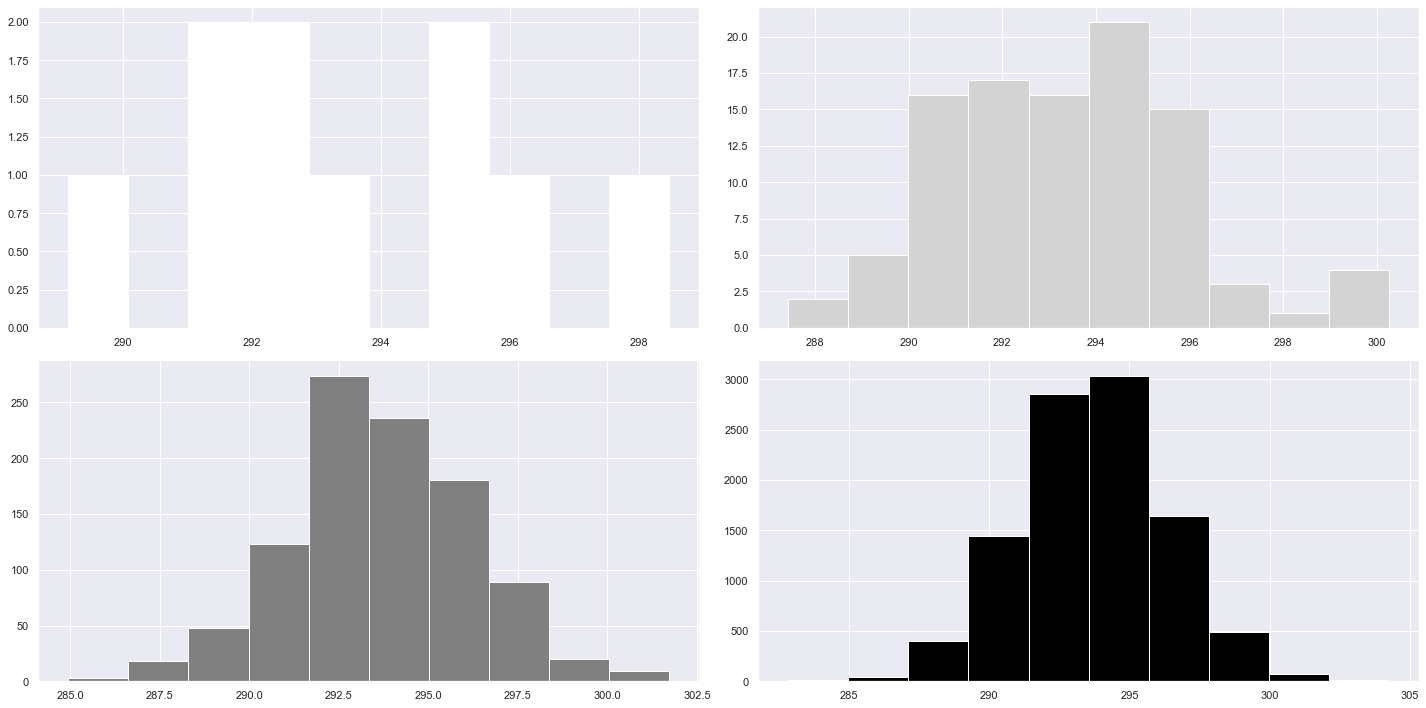

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axs[0][0].hist(n_10,    color ='white')
axs[0][1].hist(n_100,   color ='lightgrey')
axs[1][0].hist(n_1000,  color = 'grey')
axs[1][1].hist(n_10000, color='black')
plt.tight_layout()

In the diagrams above we see the central limit theorem in action. As the number of samples increases from `10` to `10,000` we see the distribution becoming more "normal". This is shown in the diagram above as the colors darken from white to gray and then to black.

As the last one is the most "normal" - we will use `n_10000` to calculate the mean and standard deviation of our data.

In [20]:
np.mean(n_10000), np.std(n_10000)

(293.70145276666665, 2.602810963377887)

Therefore, we have a general understanding of the AOV discussion for this dataset.

Author: Mahtab Khan